In [30]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

In [31]:
data = pd.read_csv("/Users/farhat/Documents/Project/ProcessedData/fullData.csv")

# Training data and Label data split
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

#Train test split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, Y,                 # Features and labels
                                                    test_size=0.2,        # 20% for testing
                                                    random_state=42,      # Ensures reproducibility
                                                    stratify=Y            # (Optional) maintains label proportions
)

In [ ]:
#Sepsis label for each patient should be stored in specific .psv file in a directory of labels directory
#Each file should be named as patient_id.psv
from testing_directory import prepare_label_directory
combined, label_directory = prepare_label_directory(X_test, y_test)

In [ ]:
# Hyper paramters selection and tunning using grid search CV
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 12, 15],
    'learning_rate': [0.05, 0.1, 0.12, 0.15],
    'n_estimators': [ 200, 400, 600, 700, 800, 1000,1200]
}

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train.iloc[:,1:], y_train)

# Storing the result in a dataframe

results = pd.DataFrame(grid_search.cv_results_)
results['cv'] = grid_search.cv
results_source = 'Xgboost_Results.csv'
if os.path.exists(results_source):
    df = pd.read_csv(results_source)
    results = pd.concat([df, results], ignore_index=True)
    results.to_csv('Xgboost_Results.csv')
else:
    results.to_csv('Xgboost_Results.csv')


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Exception ignored in: <function ResourceTracker.__del__ at 0x10a6d9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107351bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x11006dbc0>
Traceback (most recent call last

In [34]:
best_param = grid_search.best_params_
testing_best_param = pd.DataFrame([best_param])
testing_best_param['cv']=grid_search.cv
testing_best_param

,learning_rate,max_depth,n_estimators,cv
0,0.15,12,1200,5


In [35]:
# Best model estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test.iloc[:,1:])

In [36]:
# Accuracy Score
y_pred = y_pred[:,1] # Probability of 1
y_pred_binary = (y_pred >=0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
testing_best_param['accuracy']=accuracy
print(f"Tuned Model Accuracy: {accuracy:.4f}")

Tuned Model Accuracy: 0.9962


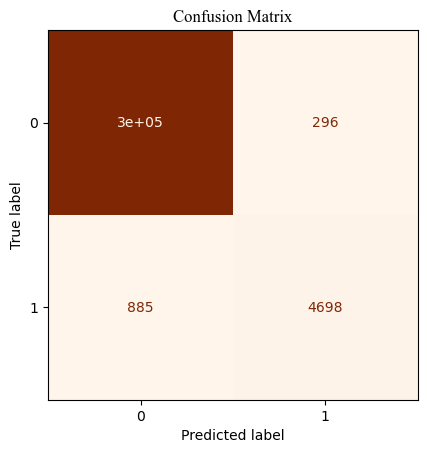

In [45]:
cm =confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Oranges', colorbar=False)  # You can change the color map
testing_best_param['TN']=cm[0,0]
testing_best_param['FP']=cm[0,1]
testing_best_param['FN']=cm[1,0]
testing_best_param['TP']=cm[1,1]
plt.title("Confusion Matrix", fontsize=12, fontname='Times New Roman')
plt.show()


In [48]:
#Similar to the label directory, predictions should be stored in a directory
#The y_pred should be probability of the prediction not the label
#Each file is named as patient_id.psv
from testing_directory import prepare_prediction_directory
prediction_directory = prepare_prediction_directory(combined, y_pred)

In [40]:
from evaluate_sepsis_score import evaluate_sepsis_score #Importing the utility score function from the file provided by the challenge organizers

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
testing_best_param[['auroc','auprc', 'accuracy', 'f_measure', 'utility']] = [auroc, auprc, accuracy, f_measure, utility]
if os.path.exists('testing_best_param.csv'):
    test_df = pd.read_csv('testing_best_param.csv')
    testing_best_param = pd.concat([test_df, testing_best_param], axis=0)
    testing_best_param.to_csv('testing_best_param.csv')   
else:
    testing_best_param.to_csv('testing_best_param.csv')